#Install libraries

In [ ]:
# Uncomment to install phasorpy and ptufile
print("Installing necessary libraries...")
#!pip install phasorpy > /dev/null 2>&1
#!pip install ptufile > /dev/null 2>&1
#!pip install PyQt5 > /dev/null 2>&1
#!pip install napari[all] > /dev/null 2>&1
#!pip install git+https://github.com/RoccoDAnt/napari-superres.git > /dev/null 2>&1
#!pip install cmcrameri
print("Libraries installed successfully.")

Installing necessary libraries...
Libraries installed successfully.


## Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Load libraries

In [ ]:
from phasorpy.datasets import fetch
from phasorpy.io import signal_from_ptu
from phasorpy.plot import plot_signal_image, plot_phasor_image, PhasorPlot

from phasorpy.phasor import phasor_from_signal, phasor_threshold, phasor_filter_median
from phasorpy.phasor import (
    lifetime_to_signal,
    phasor_calibrate,
    phasor_from_lifetime,
    phasor_from_signal,
)

import numpy as np
import cmcrameri.cm as cmc
from matplotlib import colors
import matplotlib.pyplot as plt

## Load data

In [ ]:
img_data = '/content/drive/MyDrive/2025/Beads/Series043_CONFOCAL.ptu'
#img_data = '/content/drive/MyDrive/2025/Articulos/MSSR-FLIM/Codes/Series043_CONFOCAL.ptu'

#img_data = fetch('hazelnut_FLIM_single_image.ptu'). ## This is sample data
signal = signal_from_ptu(img_data)
frequency = signal.attrs['frequency']

### Uncoment to analyze a single experiment
#signal = signal[0, :, :, 0]


#####  Uncoment to average four replicates
mean_signal = np.mean(signal, axis=0)  # Shape: (512, 512, 1, 132)
signal = np.squeeze(mean_signal, axis=2)
#### Uncoment to remove IRF
#signal = signal[:,:,1:74]


#### Analyze data
mean, real, imag = phasor_from_signal(signal, axis='H')

In [ ]:
# Load reference lifetime dictionary from the file
import pickle

ref_data =  '/content/drive/MyDrive/2025/Beads/ref_dict.pkl'

with open(ref_data, "rb") as f:
    ref_dict = pickle.load(f)

# Verify loaded data
print(ref_dict.keys())  # Should output: dict_keys(['frequency', 'lifetime', 'F(t)'])
print("Frequency:", ref_dict["frequency"])
print("Lifetime:", ref_dict["lifetime"])
print("First 5 F(t) values:", ref_dict["F(t)"][:5])

reference_lifetime = ref_dict["lifetime"]
reference_signal =  ref_dict["F(t)"]
reference_frequency = ref_dict["frequency"]

dict_keys(['frequency', 'lifetime', 'F(t)'])
Frequency: 78.02
Lifetime: 4.1
First 5 F(t) values: <xarray.DataArray (H: 5)> Size: 40B
array([0.00128078, 0.00122547, 0.00128651, 0.00128174, 0.00126839])
Coordinates:
    C        uint8 1B 0
  * H        (H) float64 40B 0.0 0.09697 0.1939 0.2909 0.3879


In [ ]:
# Load reference lifetime from PTU refrence file

#ref_data = '/content/drive/MyDrive/2025/Beads/Reference/ATTO488_LaserPower10_10FrameAccum_40MHz.ptu'

#ref_signal = signal_from_ptu(ref_data)
#ref_frequency = ref_signal.attrs['frequency']
#ref_lifetime = 4.1 #The expected lifetime from the ATTO488 fluorophore at the actual experimental coditions
### Uncoment to analyze a single experiment
#signal = signal[0, :, :, 0]


#####  Uncoment to average four replicates
#mean_ref_signal = np.mean(ref_signal, axis=0)  # Shape: (512, 512, 1, 132)
#ref_signal = np.squeeze(mean_ref_signal, axis=2)
#### Uncoment to remove IRF
#ref_signal = ref_signal[:,:,1:74]


#### Analyze data
#ref_mean, ref_real, ref_imag = phasor_from_signal(ref_signal, axis='H')

## Explore data

In [ ]:
#print("Signal Values:\n", signal.values)
print("\nSignal Data Type:", signal.dtype)
print("\nSignal Shape:", signal.shape)
print("\nSignal Dimensions:", signal.dims)
print("\nSignal 'H' Coordinates Data:\n", signal.coords['H'].data)
#print("\nSignal Frequency Attribute:", signal.attrs['frequency'])


Signal Data Type: float64

Signal Shape: (512, 512, 132)

Signal Dimensions: ('Y', 'X', 'H')

Signal 'H' Coordinates Data:
 [ 0.          0.0969697   0.19393939  0.29090909  0.38787879  0.48484848
  0.58181818  0.67878788  0.77575758  0.87272727  0.96969697  1.06666667
  1.16363636  1.26060606  1.35757576  1.45454545  1.55151515  1.64848485
  1.74545455  1.84242424  1.93939394  2.03636364  2.13333333  2.23030303
  2.32727273  2.42424242  2.52121212  2.61818182  2.71515152  2.81212121
  2.90909091  3.00606061  3.1030303   3.2         3.2969697   3.39393939
  3.49090909  3.58787879  3.68484848  3.78181818  3.87878788  3.97575758
  4.07272727  4.16969697  4.26666667  4.36363636  4.46060606  4.55757576
  4.65454545  4.75151515  4.84848485  4.94545455  5.04242424  5.13939394
  5.23636364  5.33333333  5.43030303  5.52727273  5.62424242  5.72121212
  5.81818182  5.91515152  6.01212121  6.10909091  6.20606061  6.3030303
  6.4         6.4969697   6.59393939  6.69090909  6.78787879  6.88484848


## Plot data raw

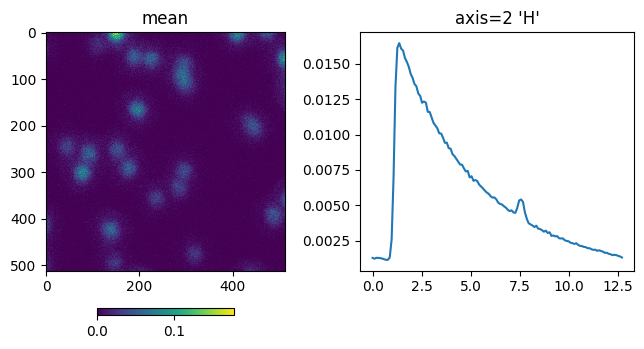

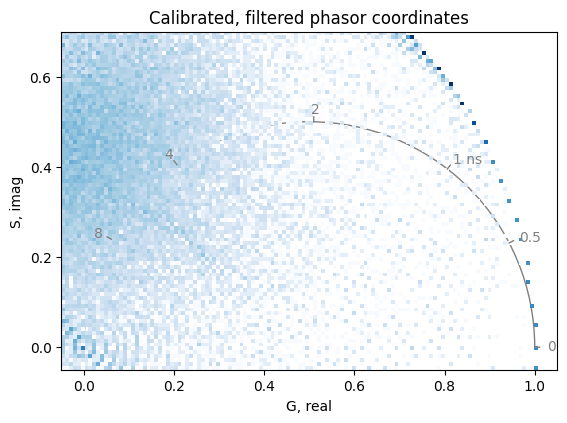

In [ ]:
plot_signal_image(signal, axis='H')
mean, real, imag = phasor_from_signal(signal, axis='H')

phasorplot = PhasorPlot(
    frequency=frequency, title='Calibrated, filtered phasor coordinates'
)
phasorplot.hist2d(real, imag)
phasorplot.show()

## Synthesize a TD-FLIM reference signal, taking as an example the mean value of an experiment of fluorescent beads with a lifetime of 4.1 ns.

In [ ]:
img_reference_signal = np.zeros(signal.shape)

for x in range(img_reference_signal.shape[0]):  # Loop over x-dimension
    for y in range(img_reference_signal.shape[1]):  # Loop over y-dimension
        img_reference_signal[x, y, :] = reference_signal  # Assign time-domain signal

#assert reference_signal.attrs['frequency'] == frequency
img_reference_mean, img_reference_real, img_reference_imag = phasor_from_signal(
    img_reference_signal
)


## Calibrate phasor coordinates, filter and threshold

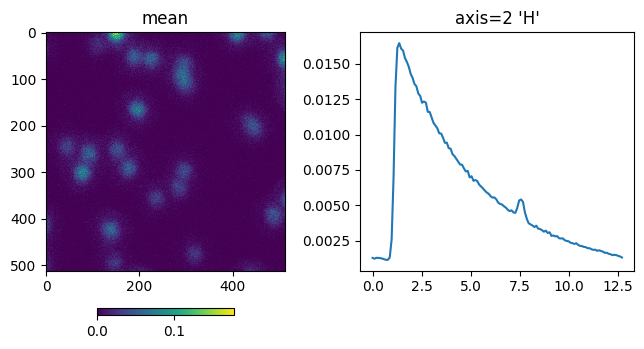

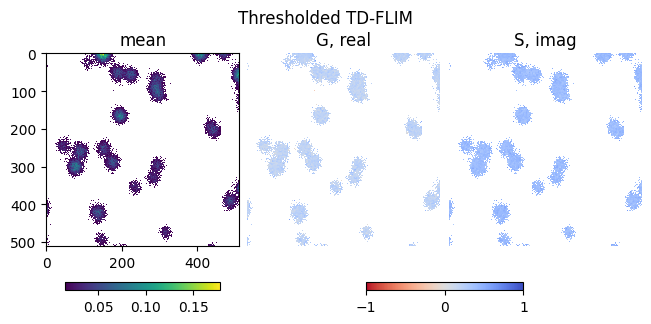

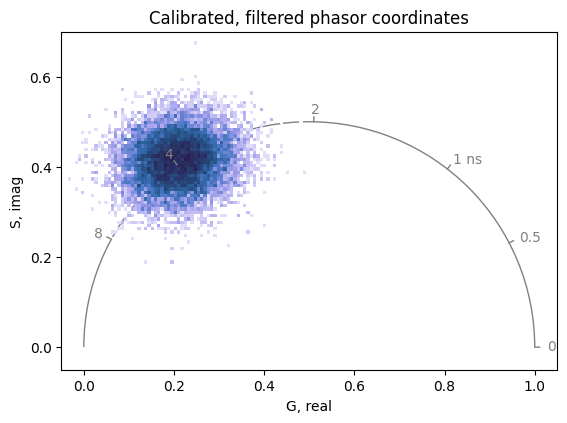

In [ ]:
## Calibrate from synthetic reference
real_cal, imag_cal = phasor_calibrate(real, imag, img_reference_mean, img_reference_real, img_reference_imag, frequency=reference_frequency, lifetime=reference_lifetime)

## Calibrate from PTU reference
#real_cal, imag_cal = phasor_calibrate(real, imag, ref_mean, ref_real, ref_imag, frequency=ref_frequency, lifetime=ref_lifetime)

## Median filter
mean_mf, real_mf, imag_mf = phasor_filter_median(mean, real_cal, imag_cal, size=3, repeat=3)
## Threshold
mean_th, real_th, imag_th = phasor_threshold(mean_mf, real_mf, imag_mf, mean_min=0.015)

#Plot
color = 'cmc.devon_r'
plot_signal_image(signal, axis='H')
plot_phasor_image(mean_th, real_th, imag_th, title='Thresholded TD-FLIM')

phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_th, imag_th, bins = 150, cmap = color)


# Fluorescence decay Plot

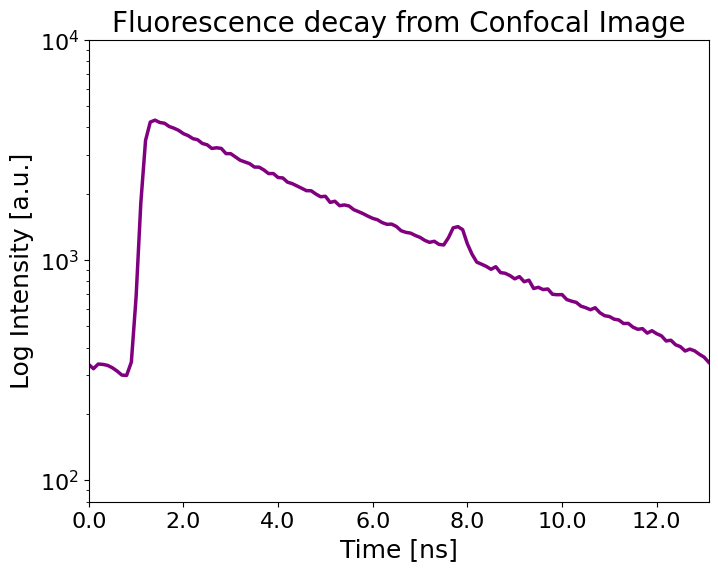

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tcspc(signal, axis='H', title='TCSPC Histogram'):
    """
    Extract and plot the TCSPC histogram from a time-resolved signal stack.

    Parameters:
    -----------
    signal : array_like
        Time-resolved image stack, e.g., shape (time_bins, x, y).
    axis : str, optional
        Axis containing the time bin information. Default is 'H'.
    title : str, optional
        Title of the plot.

    Returns:
    --------
    None
    """
    # Get the dimension number corresponding to the specified axis
    time_axis_dim = signal.get_axis_num(axis)

    # Average or sum over the image axes (assume last two are image axes)
    tcspc_histogram = np.sum(signal, axis=tuple(i for i in range(signal.ndim) if i != time_axis_dim))

    # Plot the TCSPC histogram
    titlesize = 20
    axistitle = 18
    ticksize = 16
    line = 2.5
    fig, ax = plt.subplots(figsize=(8, 6)) # Create a figure and an axes object
    ax.plot(tcspc_histogram, linewidth = line, color = 'purple')  # Plot on the axes object
    plt.xlabel('Time [ns]', fontsize = axistitle)
    plt.ylabel('Log Intensity [a.u.]', fontsize = axistitle)
    plt.xticks(fontsize = ticksize)
    plt.yticks(fontsize = ticksize)
    plt.title(title, fontsize=titlesize)
    plt.grid(False)

    # Modify x-axis ticks by dividing by 10
    new_ticks = [x / 10 for x in plt.xticks()[0]]
    plt.xticks(plt.xticks()[0], new_ticks)
    plt.xlim(0, 131)
    plt.ylim(80, 10000)
    ax.set_yscale('log') # Call set_yscale on the axes object

    #plt.legend()
    plt.show()

    return fig, tcspc_histogram


fig, tcspc = plot_tcspc(signal, axis='H', title='Fluorescence decay from Confocal Image')

# Modulation Lifetime map

## Functions for this part

In [ ]:
## Funtion to calculate the modulation and phase

def mode_and_phase(G,S,laser_period_in_seconds, harmonic = 1, color = color):
    from matplotlib.ticker import FormatStrFormatter
    # A function to calculate the modulation, phase delay
    T = laser_period_in_seconds
    T_nano = T*1e9          #to show in nanoseconds
    n = harmonic # number of harmonic (default 1)
    w = (2 * np.pi * n) / T
    w_nano = (2 * np.pi) / T_nano
    # Setting epsilon to avoid division by zero
    #epsilon = np.nan

    #G = np.where(G > 0, G, epsilon)
    #S = np.where(S > 0, S, epsilon)

    mod = np.sqrt(G**2 + S**2)
    phi = np.arctan2(S,G)

    #mod_min = np.min(mod)
    #mod_max = np.max(mod)

    phi_max = np.max(phi)
    phi_min = np.min(phi)

    #Phase correction
    quarter_pi = np.arctan(1)
    phi[phi==quarter_pi] = 0

    #Output figure

    color = color
    titlesize = 18
    suptitle = 18
    axsize = 16
    ticksize = 14

    ##Images of TD_FLIM and the phasor plot
    f, ax = plt.subplots(1,2, figsize = (7,4.5))

    #Modulation Map
    im00 = ax[0].imshow(mod, cmap=color, vmin = 0, vmax= 1)
    ax[0].axis('off')
    ax[0].set_title('Modulation Map', fontsize=titlesize)
    cbar00 = f.colorbar(im00, ax = ax[0], fraction=0.046, pad=0.04)
    cbar00.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cbar00.set_label('Modulation [a.u.]', fontsize=axsize)
    cbar00.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
    ax[0].legend(bbox_to_anchor=(1.5, -0.2), loc='lower center', ncol=2, fontsize = ticksize) #-0.2
    #ax[0,0].set_box_aspect(1)

    #Phase Map
    im01 = ax[1].imshow(phi, cmap=color)
    ax[1].axis('off')
    ax[1].set_title('Phase Map', fontsize=titlesize)
    cbar01 = f.colorbar(im01, ax = ax[1], fraction=0.046, pad=0.04)
    cbar01.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    cbar01.set_label('Phase angle [rad]', fontsize=axsize)
    cbar01.ax.tick_params(labelsize=ticksize)  # Adjust tick label size
    #ax[0,1].set_box_aspect(1)

    f.suptitle('Modulation and Phase maps',x=0.5, y=0.99, fontsize = suptitle)
    f.subplots_adjust(wspace=0.3, hspace=0.3, top=0.9, bottom=0.1, left=0.05, right=0.95)
    plt.show()

    return mod, phi, f

## Function to calculate the modulation lifetime map

def mod_lifetime(mod,laser_period_in_seconds, harmonic = 1, color = color):
    from matplotlib.ticker import FormatStrFormatter
    # A function to calculate the modulation lifetimes of an image
    T = laser_period_in_seconds
    T_nano = T*1e9          #to show in nanoseconds
    n = harmonic # number of harmonic (default 1)
    w = (2 * np.pi * n) / T
    w_nano = (2 * np.pi) / T_nano

    tau_m = (1 / w) * np.sqrt(np.maximum((1/(mod**2))-1,0))
    tau_m = tau_m*1e9   #to show in nanoseconds
    #tau_m_min = np.min(tau_m)
    #tau_m_max = np.max(tau_m)
    barlabel = 'ns'
    title = 'Modulation Lifetime map'

    #Output figure

    color = color
    titlesize = 25
    axsize = 22
    ticksize = 20

    #Tau_m Map

    plt.figure(figsize=(7, 5))
    im = plt.imshow(tau_m, cmap=color, vmin = 0, vmax= T_nano)
    plt.axis('off')
    plt.title(title, fontsize = titlesize, pad = 25)

    # Colorbar
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label(barlabel, fontsize = axsize)  # Add a label if needed
    cbar.ax.tick_params(labelsize=ticksize)

    # Hide axis
    plt.axis('off')

    # Show plot
    plt.show()

    return tau_m, f

def phase_lifetime(G,S,laser_period_in_seconds, harmonic = 1, color = color):
    from matplotlib.ticker import FormatStrFormatter
    # A function to calculate the modulation lifetimes of an image
    T = laser_period_in_seconds
    T_nano = T*1e9          #to show in nanoseconds
    n = harmonic # number of harmonic (default 1)
    w = (2 * np.pi * n) / T
    w_nano = (2 * np.pi) / T_nano

    tau_p = (1 / w) * S/G
    tau_p = tau_p*1e9   #to show in nanoseconds
    #tau_m_min = np.min(tau_m)
    #tau_m_max = np.max(tau_m)
    barlabel = 'Phase Lifetime [ns]'
    title = 'Phase Lifetime map'

    #Output figure

    color = color
    titlesize = 18
    axsize = 16
    ticksize = 14

    #Tau_p Map

    plt.figure(figsize=(7, 5))
    im = plt.imshow(tau_p, cmap=color, vmin = 0, vmax= T_nano)
    plt.axis('off')
    plt.title(title, fontsize = titlesize, pad = 25)

    # Colorbar
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label(barlabel, fontsize = axsize)  # Add a label if needed
    cbar.ax.tick_params(labelsize=ticksize)

    # Hide axis
    plt.axis('off')

    # Show plot
    plt.show()

    return tau_p, f

## Modulation, Phase and Modulation Lifetime Maps

<ipython-input-255-3ce7a954bca2>:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend(bbox_to_anchor=(1.5, -0.2), loc='lower center', ncol=2, fontsize = ticksize) #-0.2


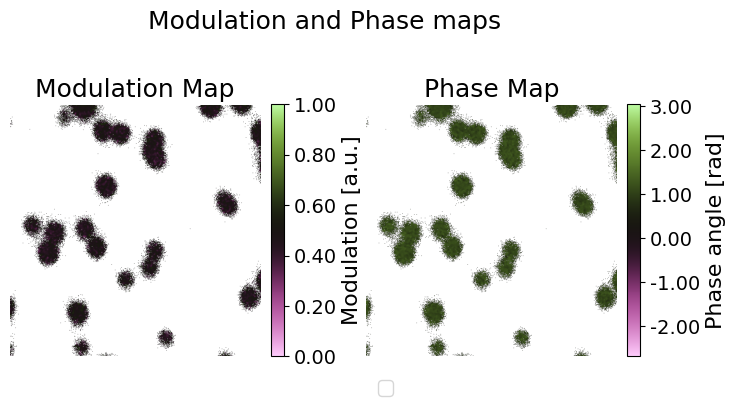

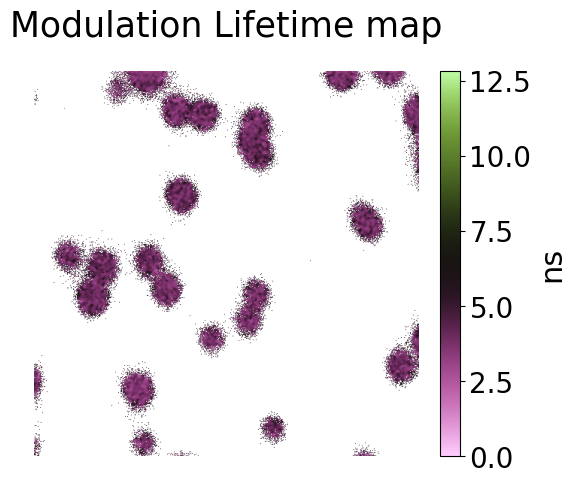

In [ ]:
# Parameters for TD-FLIM figure
T = (1 / frequency) * 1e3
T_nano = T*1e9
laser_period_in_seconds = T * 1e-9
color = 'cmc.vanimo'

#Modulation and Phase for Confocal
mod_th, phase_th, f_mod_phi = mode_and_phase(real_th,imag_th,laser_period_in_seconds, harmonic = 1, color = color)

#Modulation Lifetime for Confocal
tau_m_th, f_modLT = mod_lifetime(mod_th,laser_period_in_seconds, harmonic = 1, color = color)

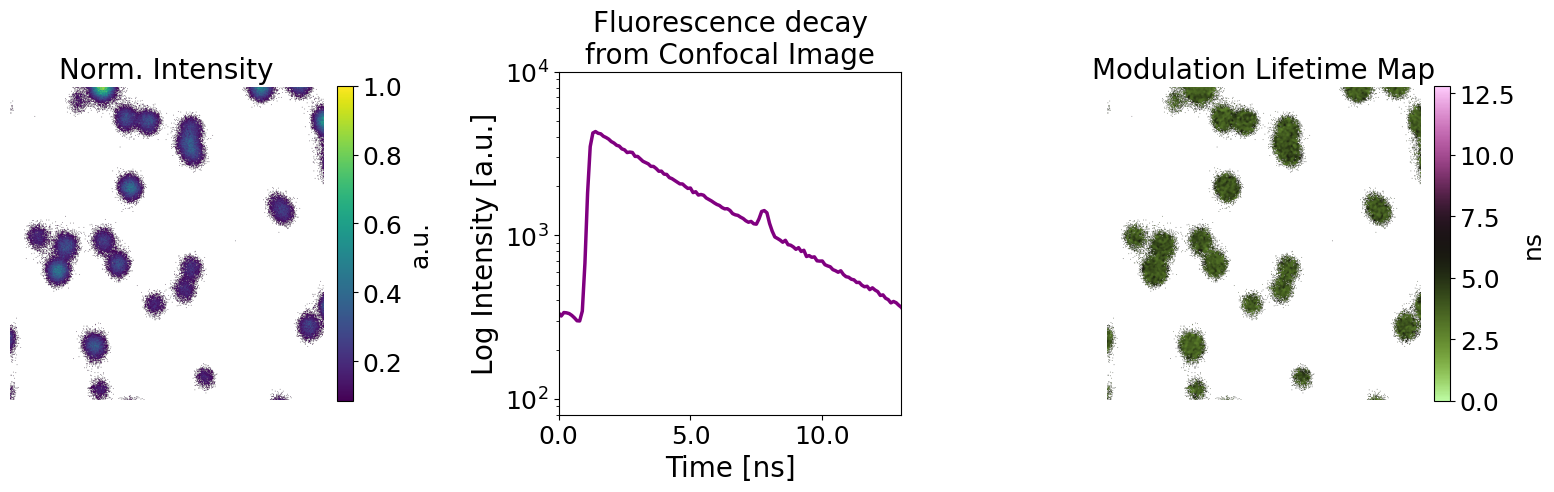

In [ ]:
import matplotlib.gridspec as gridspec

# Images to plot
num_mean_th = np.nan_to_num(mean_th,0)
intensity = num_mean_th
norm_intensity = intensity / np.max(intensity)
norm_intensity = np.where(norm_intensity == 0, np.nan, norm_intensity)
#norm_intensity = intensity / np.max(intensity)
decay = tcspc
modLT = tau_m_th
decay_title = 'Fluorescence decay\nfrom Confocal Image'

suptitle = 22
titlesize = 20
axistitle = 18
axsize = 16
tau_m_label = 'Modulation Lifetime [ns]'
ticksize = 16
line = 2.5
color = 'viridis'
color_2 = 'cmc.vanimo_r'

# Plot parameters
suptitle = 25
titlesize = 20
axistitle = 20
axsize = 18
tau_m_label = 'ns'
ticksize = 18
line = 2.5

## Layout with GridSpec for equal horizontal spacing
f = plt.figure(figsize=(16, 8))
spec = gridspec.GridSpec(1, 3, figure=f, wspace=0.6)  # Control spacing here

# Intensity Map
ax0 = f.add_subplot(spec[0])
im00 = ax0.imshow(norm_intensity, cmap=color)
ax0.axis('off')
ax0.set_title('Norm. Intensity', fontsize=titlesize)
cbar00 = f.colorbar(im00, ax=ax0, fraction=0.046, pad=0.04)
cbar00.set_label('a.u.', fontsize=axsize)
cbar00.ax.tick_params(labelsize=ticksize)
ax0.set_box_aspect(1)

# Fluorescence Decay Plot
ax1 = f.add_subplot(spec[1])
ax1.plot(decay, linewidth=line, color='purple')
ax1.set_xlabel('Time [ns]', fontsize=axistitle)
ax1.set_ylabel('Log Intensity [a.u.]', fontsize=axistitle)
ax1.tick_params(axis='both', labelsize=ticksize)
ax1.set_title(decay_title, fontsize=titlesize)
ax1.grid(False)
new_ticks = [x / 10 for x in ax1.get_xticks()]
ax1.set_xticks(ax1.get_xticks(), new_ticks)
ax1.set_xlim(0, 130)
ax1.set_ylim(80, 10000)
ax1.set_yscale('log')
ax1.set_box_aspect(1)

# Tau_m Map
ax2 = f.add_subplot(spec[2])
im02 = ax2.imshow(modLT, cmap=color_2, vmin = 0, vmax= T)
ax2.axis('off')
ax2.set_title('Modulation Lifetime Map', fontsize=titlesize)
cbar10 = f.colorbar(im02, ax=ax2, fraction=0.046, pad=0.04)
cbar10.set_label(tau_m_label, fontsize=axsize)
cbar10.ax.tick_params(labelsize=ticksize)
ax2.set_box_aspect(1)

# Main Title and Adjustments
#f.suptitle('Modulation, Decay, and Modulation Lifetime Maps', x=0.5, y=0.87, fontsize=suptitle)
f.subplots_adjust(top=0.85, bottom=0.15, left=0.05, right=0.95)

plt.show()

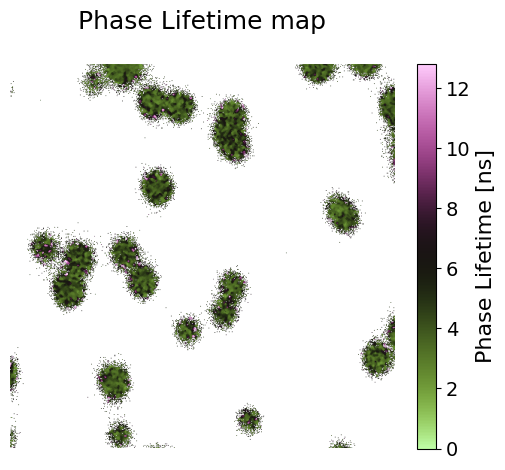

In [ ]:
#Phase Lifetime for Confocal
color = 'cmc.vanimo_r'
tau_p_th, f_phaseLT = phase_lifetime(real_th, imag_th,laser_period_in_seconds, harmonic = 1, color = color)

# Cursors for reciprocity principle

In [ ]:
from phasorpy.color import CATEGORICAL
from phasorpy.cursors import (
    mask_from_circular_cursor,
    mask_from_elliptic_cursor,
    mask_from_polar_cursor,
    pseudo_color,
)
from phasorpy.datasets import fetch
from phasorpy.io import signal_from_lsm
from phasorpy.phasor import phasor_from_signal, phasor_threshold
from phasorpy.plot import PhasorPlot

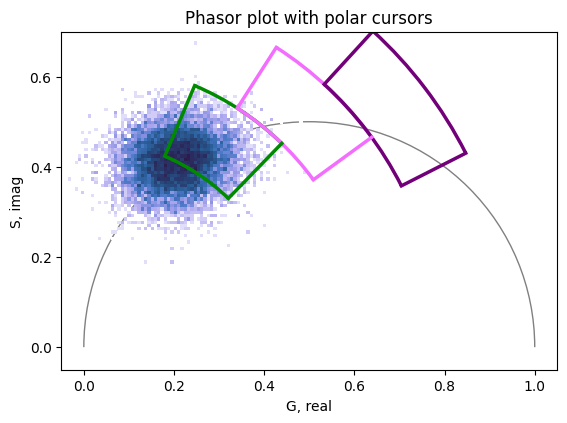

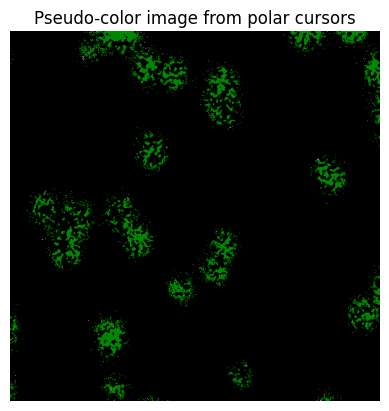

In [ ]:
# Polar cursors

real = real_th
imag = imag_th
intensity = None

# number and position of cursors
cursors_real = [0.27, 0.5]
cursors_imag = [0.4, 0.5]

#Phase and Modulation limits for cursors
phase_min = [0.8, 0.63, 0.47]
phase_max = [1.17, 1.0, 0.83]
modulation_min = [0.46, 0.63, 0.79]
modulation_max = [0.63, 0.79, 0.95]


line = 2.5
color = 'cmc.devon_r'
bins = 150

polar_mask = mask_from_polar_cursor(
    real, imag, phase_min, phase_max, modulation_min, modulation_max
)

plot = PhasorPlot(allquadrants=False, title='Phasor plot with polar cursors')
plot.hist2d(real, imag, cmap=color, bins = bins)
for i in range(len(phase_min)):
    plot.polar_cursor(
        phase=phase_min[i],
        phase_limit=phase_max[i],
        modulation=modulation_min[i],
        modulation_limit=modulation_max[i],
        color=CATEGORICAL[i + 2],
        linestyle='-', linewidth = line
    )
plot.show()

pseudo_color_beads = pseudo_color(*polar_mask, intensity = intensity, colors=CATEGORICAL[2:])

fig, ax = plt.subplots()
ax.set_title('Pseudo-color image from polar cursors')
ax.imshow(pseudo_color_beads)
plt.axis('off')
plt.show()

## Sharpen the mean image with MSSR

In [ ]:
from napari_superres.core_mssr import mssr_class
mssr_instance = mssr_class()
import cmcrameri.cm as cmc

In [ ]:
### Parameters for MSSR
sigma_px = 49
fwhm = 2.35 * sigma_px  # Full Width at Half Maximum
amp = 1  # Amplitude
order = 1  # Order
mesh = True  # Optional, default is True
ftI = False  # Optional, default is False
intNorm = False  # Optional, default is True

progress: 100%|██████████| 117/117 [01:30<00:00,  1.29it/s]


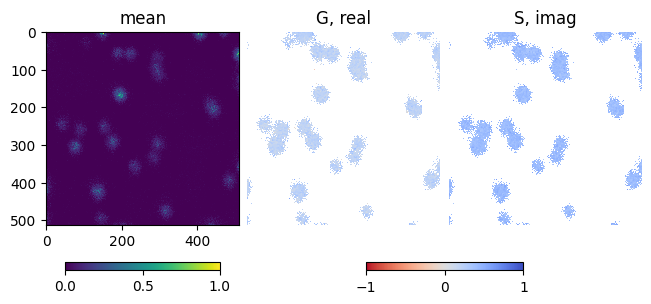

In [ ]:
#Apply MSSR0
#mean_mssr0 = mssr_instance.sfMSSR(img=mean, fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm)
#plot_phasor_image(mean_mssr0, real, imag)

#Apply MSSR1
mean_mssr1 = mssr_instance.sfMSSR(img=mean, fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm)
plot_phasor_image(mean_mssr1, real, imag)

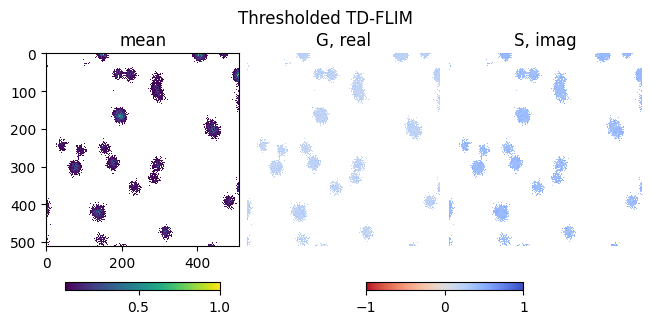

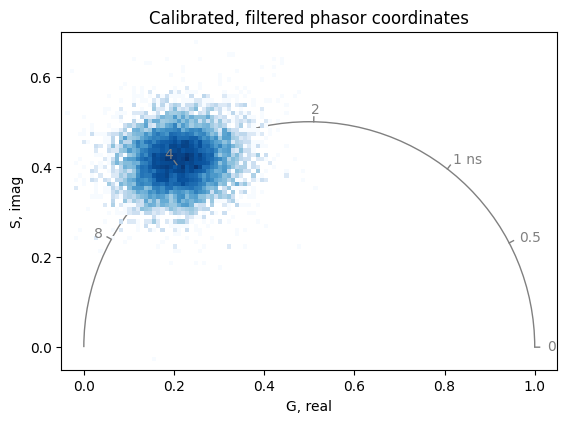

In [ ]:
from phasorpy.phasor import phasor_threshold

color = 'PRGn'

#Threshold for MSSR0
#mean_th, real_th, imag_th = phasor_threshold(mean_mssr0, real, imag, mean_min=0.1)
#plot_phasor_image(mean_th, real_th, imag_th, title='Thresholded TD-FLIM')
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_th, imag_th, bins = 120)

#Threshold for MSSR1
mean_th_mssr1, real_th_mssr1, imag_th_mssr1 = phasor_threshold(mean_mssr1, real, imag, mean_min=0.05)
plot_phasor_image(mean_th_mssr1, real_th_mssr1, imag_th_mssr1, title='Thresholded TD-FLIM')
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_th_mssr1, imag_th_mssr1, bins = 120)

# TD-FL image (lifetime maps) from Phasor coordinates #

<ipython-input-255-3ce7a954bca2>:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend(bbox_to_anchor=(1.5, -0.2), loc='lower center', ncol=2, fontsize = ticksize) #-0.2


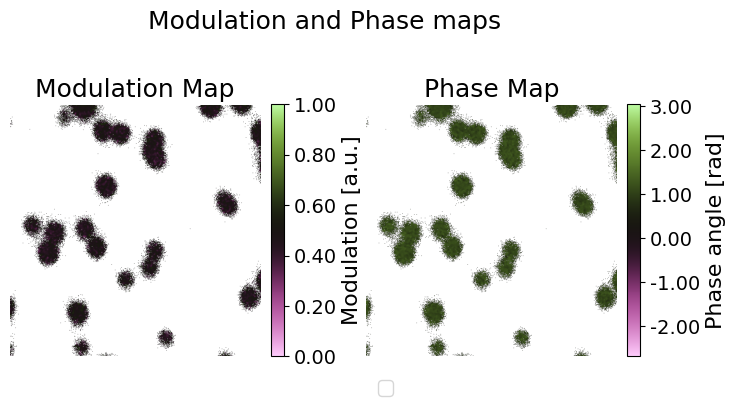

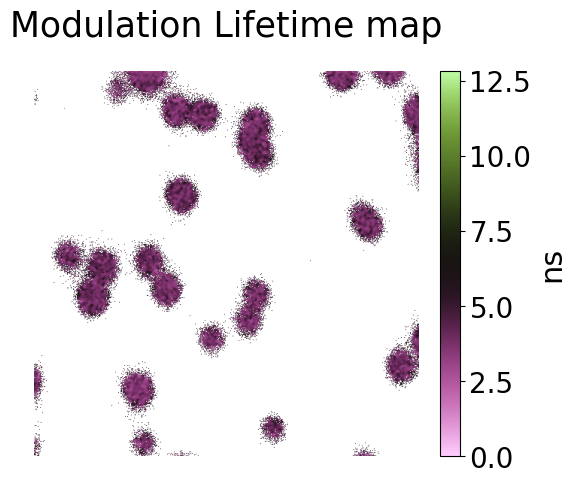

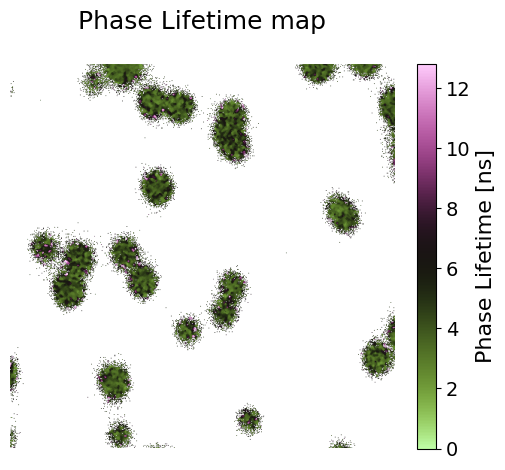

In [ ]:
color = 'cmc.vanimo'

#Modulation and Phase for Confocal_MSSR0
#mod_th_mssr0, phase_th_mssr0, f_mod_phi_mssr0 = mode_and_phase(real_th,imag_th,laser_period_in_seconds, harmonic = 1, color = color)

#Modulation Lifetime for Confocal_MSSR0
#tau_m_th_mssr0, f_modLT_mssr0 = mod_lifetime(mod_th_mssr0,laser_period_in_seconds, harmonic = 1, color = color)

#Phase Lifetime for Confocal_MSSR0
#color = 'cmc.vanimo_r'
#tau_p_th_mssr0, f_phaseLT_mssr0 = phase_lifetime(real_th, imag_th,laser_period_in_seconds, harmonic = 1, color = color)

#Modulation and Phase for Confocal_MSSR1
mod_th_mssr1, phase_th_mssr1, f_mod_phi_mssr1 = mode_and_phase(real_th,imag_th,laser_period_in_seconds, harmonic = 1, color = color)

#Modulation Lifetime for Confocal_MSSR1
tau_m_th_mssr1, f_modLT_mssr1 = mod_lifetime(mod_th_mssr1,laser_period_in_seconds, harmonic = 1, color = color)

#Phase Lifetime for Confocal_MSSR1
color = 'cmc.vanimo_r'
tau_p_th_mssr1, f_phaseLT_mssr1 = phase_lifetime(real_th, imag_th,laser_period_in_seconds, harmonic = 1, color = color)

## Intensity Map ##

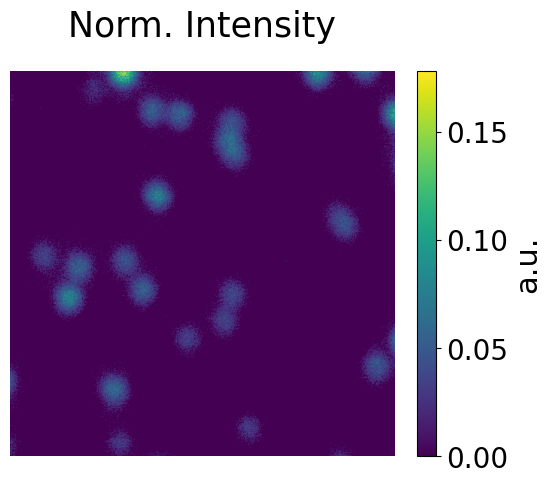

In [ ]:
fig = mean_th
title = 'Norm. Intensity'
barlabel = 'a.u.'
titlesize = 25
s =500
legend = 18
axsize = 22
ticksize = 20
color = 'viridis'

# Create figure and axis
plt.figure(figsize=(7, 5))
im = plt.imshow(fig, cmap=color)
plt.title(title, fontsize = titlesize, pad = 25)

# Colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label(barlabel, fontsize = axsize)  # Add a label if needed
cbar.ax.tick_params(labelsize=ticksize)

# Hide axis
plt.axis('off')

# Show plot
plt.show()

#Phasor analysis by cursors

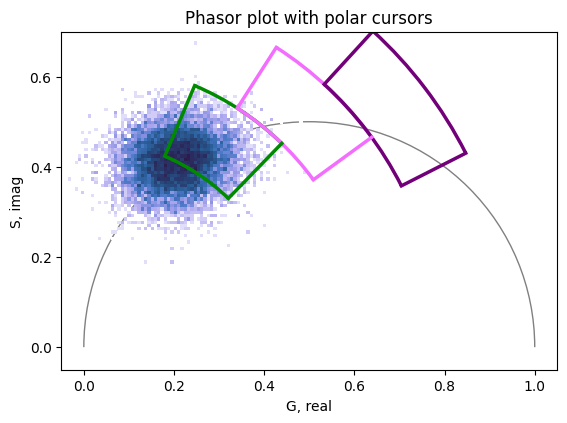

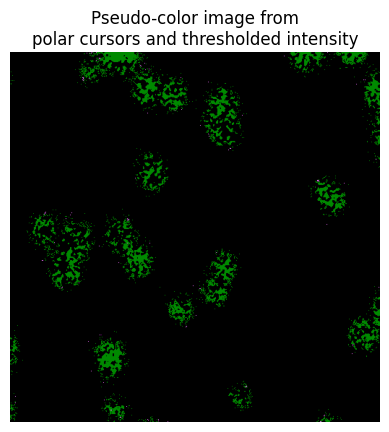

In [ ]:
# Polar cursors

real = real_th
imag = imag_th
intensity = None #mean_th

#Phase and Modulation limits for cursors
phase_min = [0.8, 0.63, 0.47]
phase_max = [1.17, 1.0, 0.83]
modulation_min = [0.46, 0.63, 0.79]
modulation_max = [0.63, 0.79, 0.95]


line = 2.5
color = 'cmc.devon_r'
bins = 150

polar_mask = mask_from_polar_cursor(
    real, imag, phase_min, phase_max, modulation_min, modulation_max
)

plot = PhasorPlot(allquadrants=False, title='Phasor plot with polar cursors')
plot.hist2d(real, imag, cmap=color, bins = bins)
for i in range(len(phase_min)):
    plot.polar_cursor(
        phase=phase_min[i],
        phase_limit=phase_max[i],
        modulation=modulation_min[i],
        modulation_limit=modulation_max[i],
        color=CATEGORICAL[i + 2],
        linestyle='-', linewidth = line
    )
plot.show()

pseudo_color_beads = pseudo_color(*polar_mask, intensity = intensity, colors=CATEGORICAL[2:])

fig, ax = plt.subplots()
ax.set_title('Pseudo-color image from\npolar cursors and thresholded intensity')
ax.imshow(pseudo_color_beads)
plt.axis('off')
plt.show()

# Zoom-in to the images

(170, 170)


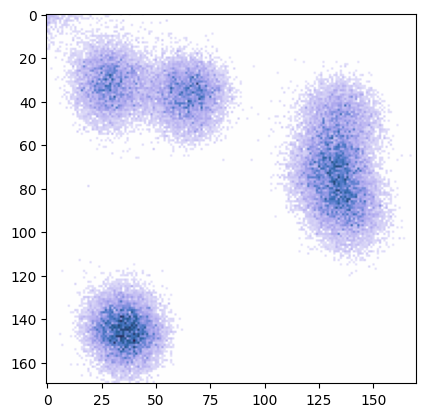

In [ ]:
mean_zoom = mean[20:190, 160:330]
real_zoom = real[20:190, 160:330]
imag_zoom = imag[20:190, 160:330]
mean_th_zoom = mean_th[20:190, 160:330]
real_th_zoom = real_th[20:190, 160:330]
imag_th_zoom = imag_th[20:190, 160:330]
plt.imshow(mean_th_zoom, cmap=color)
print(mean_th_zoom.shape)


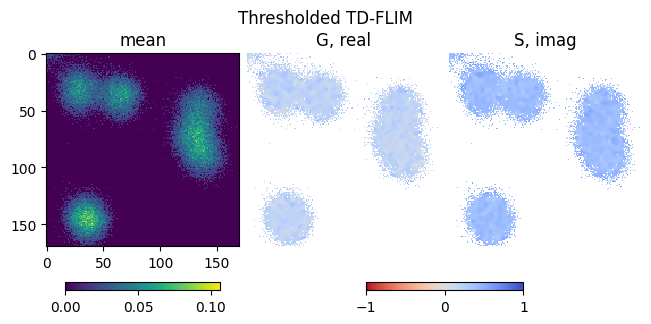

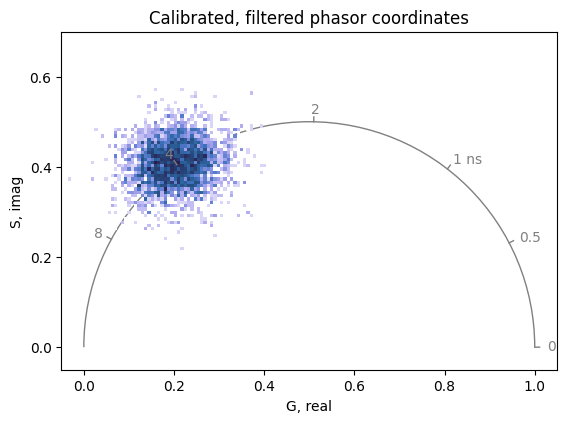

In [ ]:
color = 'cmc.devon_r'
plot_phasor_image(mean_th_zoom, real_th_zoom, imag_th_zoom, title='Thresholded TD-FLIM')

phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_th_zoom, imag_th_zoom, bins = 150, cmap = color)

<ipython-input-255-3ce7a954bca2>:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend(bbox_to_anchor=(1.5, -0.2), loc='lower center', ncol=2, fontsize = ticksize) #-0.2


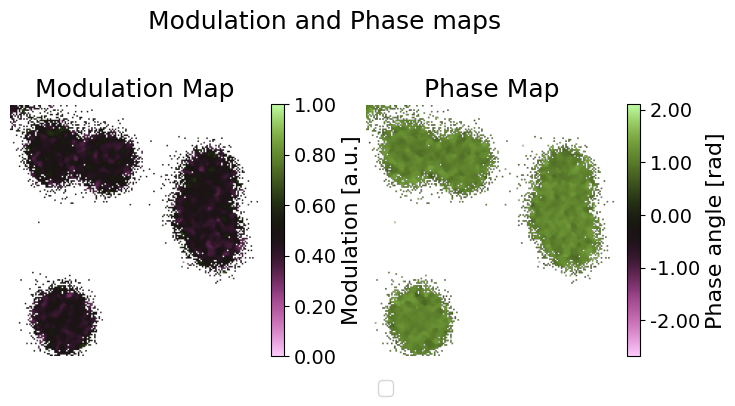

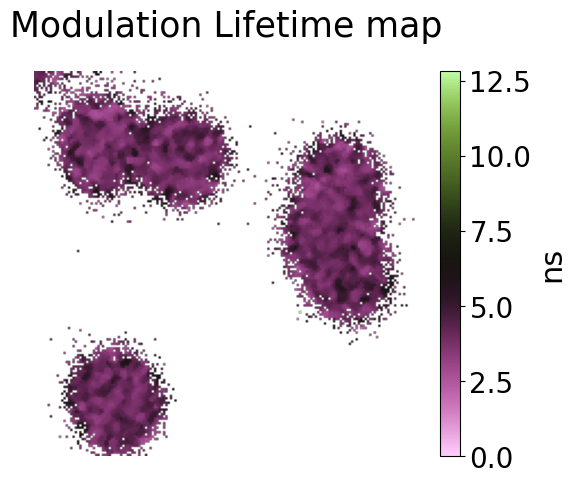

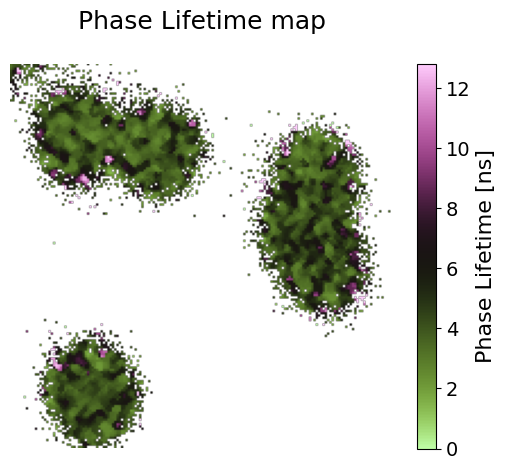

In [ ]:
# Parameters for TD-FLIM figure
T = (1 / frequency) * 1e3
T_nano = T*1e9
laser_period_in_seconds = T * 1e-9
color = 'cmc.vanimo'

#Modulation and Phase for Confocal
mod_th_zoom, phase_th_zoom, f_mod_phi_zoom = mode_and_phase(real_th_zoom,imag_th_zoom,laser_period_in_seconds, harmonic = 1, color = color)

#Modulation Lifetime for Confocal
tau_m_th_zoom, f_modLT_zoom = mod_lifetime(mod_th_zoom,laser_period_in_seconds, harmonic = 1, color = color)

#Phase Lifetime for Confocal
color = 'cmc.vanimo_r'
tau_p_th_zoom, f_phaseLT_zoom = phase_lifetime(real_th_zoom, imag_th_zoom,laser_period_in_seconds, harmonic = 1, color = color)

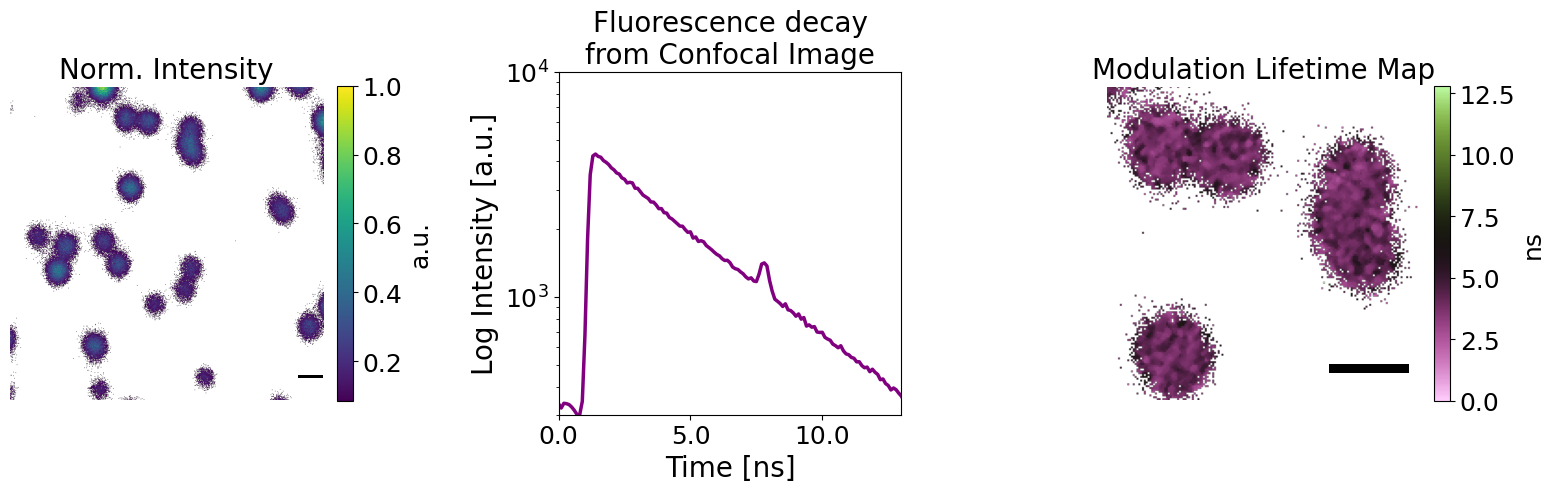

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

# Images to plot
num_mean_th = np.nan_to_num(mean_th,0)
intensity = num_mean_th
norm_intensity = intensity / np.max(intensity)
norm_intensity = np.where(norm_intensity == 0, np.nan, norm_intensity)
#norm_intensity = intensity / np.max(intensity)
decay = tcspc
modLT = tau_m_th
decay_title = 'Fluorescence decay\nfrom Confocal Image'

suptitle = 22
titlesize = 20
axistitle = 18
axsize = 16
tau_m_label = 'Modulation Lifetime [ns]'
ticksize = 16
line = 2.5
color = 'viridis'
color_2 = 'cmc.vanimo'

# Plot parameters
suptitle = 25
titlesize = 20
axistitle = 20
axsize = 18
tau_m_label = 'ns'
ticksize = 18
line = 2.5

# Add the scale bar
scalebar_width = 43  # in pixels
scalebar_height = 5  # in pixels
bar_color = 'k'  # or 'black' depending on your image

# Position: bottom left with a 10-pixel margin
x_pos1 = 470
y_pos1 = 470
x_pos2 = 120
y_pos2 = 150
scalebar1 = patches.Rectangle((x_pos1, y_pos1), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
scalebar2 = patches.Rectangle((x_pos2, y_pos2), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)

## Layout with GridSpec for equal horizontal spacing
f = plt.figure(figsize=(16, 8))
spec = gridspec.GridSpec(1, 3, figure=f, wspace=0.6)  # Control spacing here

# Intensity Map
ax0 = f.add_subplot(spec[0])
im00 = ax0.imshow(norm_intensity, cmap=color)
ax0.add_patch(scalebar1)
ax0.axis('off')
ax0.set_title('Norm. Intensity', fontsize=titlesize)
cbar00 = f.colorbar(im00, ax=ax0, fraction=0.046, pad=0.04)
cbar00.set_label('a.u.', fontsize=axsize)
cbar00.ax.tick_params(labelsize=ticksize)
ax0.set_box_aspect(1)

# Fluorescence Decay Plot
ax1 = f.add_subplot(spec[1])
ax1.plot(decay, linewidth=line, color='purple')
ax1.set_xlabel('Time [ns]', fontsize=axistitle)
ax1.set_ylabel('Log Intensity [a.u.]', fontsize=axistitle)
ax1.tick_params(axis='both', labelsize=ticksize)
ax1.set_title(decay_title, fontsize=titlesize)
ax1.grid(False)
new_ticks = [x / 10 for x in ax1.get_xticks()]
ax1.set_xticks(ax1.get_xticks(), new_ticks)
ax1.set_xlim(0, 130)
ax1.set_ylim(300, 10000)
ax1.set_yscale('log')
ax1.set_box_aspect(1)

# Tau_m Map
ax2 = f.add_subplot(spec[2])
im02 = ax2.imshow(tau_m_th_zoom, cmap=color_2, vmin = 0, vmax= T)
ax2.add_patch(scalebar2)
ax2.axis('off')
ax2.set_title('Modulation Lifetime Map', fontsize=titlesize)
cbar10 = f.colorbar(im02, ax=ax2, fraction=0.046, pad=0.04)
cbar10.set_label(tau_m_label, fontsize=axsize)
cbar10.ax.tick_params(labelsize=ticksize)
ax2.set_box_aspect(1)

# Main Title and Adjustments
#f.suptitle('Modulation, Decay, and Modulation Lifetime Maps', x=0.5, y=0.87, fontsize=suptitle)
f.subplots_adjust(top=0.85, bottom=0.15, left=0.05, right=0.95)

plt.show()

# Cursors for reciprocity principle

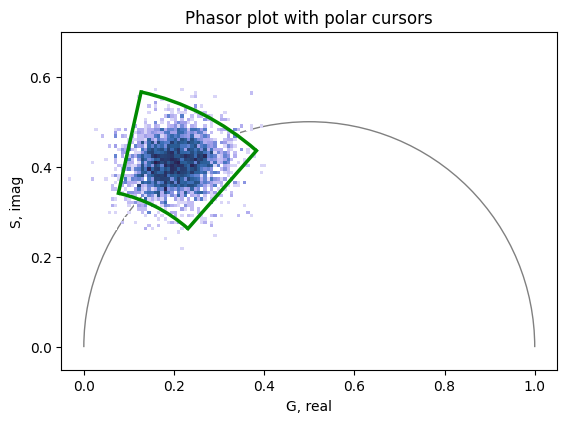

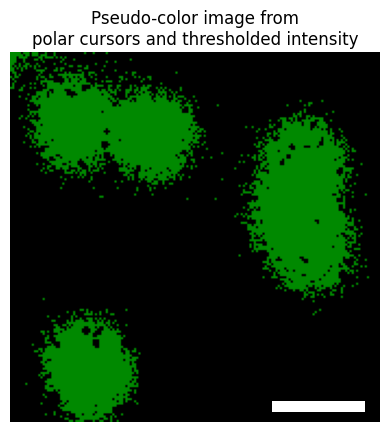

In [ ]:
import matplotlib.patches as patches
# Polar cursors

real = real_th_zoom
imag = imag_th_zoom
intensity = None #mean_th

#Phase and Modulation limits for cursors
phase_min = [0.85]#, 0.63, 0.47]
phase_max = [1.35]#, 1.0, 0.83]
modulation_min = [0.35]# , 0.63, 0.79]
modulation_max = [0.58]#, 0.79, 0.95]


line = 2.5
color = 'cmc.devon_r'
bins = 150

polar_mask = mask_from_polar_cursor(
    real, imag, phase_min, phase_max, modulation_min, modulation_max
)

plot = PhasorPlot(allquadrants=False, title='Phasor plot with polar cursors')
plot.hist2d(real, imag, cmap=color, bins = bins)
for i in range(len(phase_min)):
    plot.polar_cursor(
        phase=phase_min[i],
        phase_limit=phase_max[i],
        modulation=modulation_min[i],
        modulation_limit=modulation_max[i],
        color=CATEGORICAL[i + 2],
        linestyle='-', linewidth = line
    )
plot.show()

pseudo_color_beads = pseudo_color(*polar_mask, intensity = intensity, colors=CATEGORICAL[2:])

fig, ax = plt.subplots()
ax.set_title('Pseudo-color image from\npolar cursors and thresholded intensity')
ax.imshow(pseudo_color_beads)
# Add the scale bar
scalebar_width = 43  # in pixels
scalebar_height = 5  # in pixels
bar_color = 'white'  # or 'black' depending on your image

# Position: bottom left with a 10-pixel margin
x_pos = 120
y_pos = 160

scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax.add_patch(scalebar)
plt.axis('off')
plt.show()

# Sharpen the image with MSSR

In [ ]:
### Parameters for MSSR
sigma_px = 49
fwhm = 2.35 * sigma_px  # Full Width at Half Maximum
amp = 1  # Amplitude
order = 1  # Order
mesh = True  # Optional, default is True
ftI = False  # Optional, default is False
intNorm = False  # Optional, default is True

progress: 100%|██████████| 117/117 [00:09<00:00, 12.68it/s]


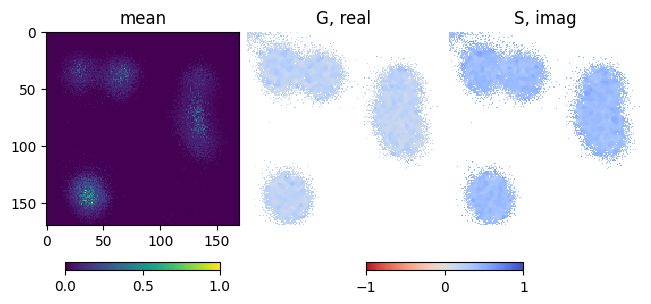

In [ ]:
#Apply MSSR0
#mean_mssr0 = mssr_instance.sfMSSR(img=mean, fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm)
#plot_phasor_image(mean_mssr0, real, imag)

#Apply MSSR1
mean_zoom_mssr1 = mssr_instance.sfMSSR(img=mean_zoom, fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm)
plot_phasor_image(mean_zoom_mssr1, real_zoom, imag_zoom)

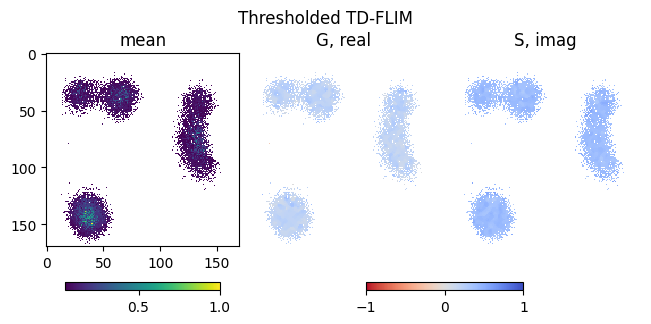

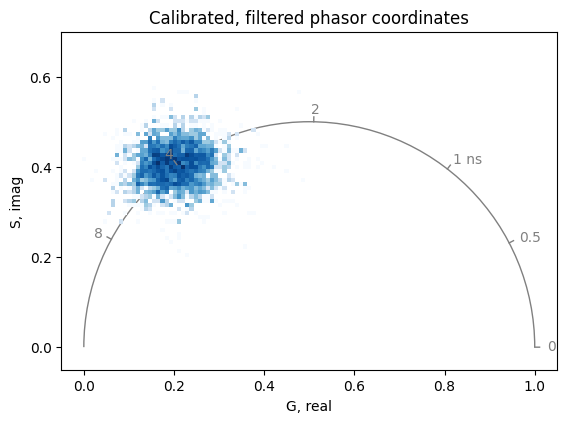

In [ ]:
from phasorpy.phasor import phasor_threshold

color = 'PRGn'

#Threshold for MSSR0
#mean_th, real_th, imag_th = phasor_threshold(mean_mssr0, real, imag, mean_min=0.1)
#plot_phasor_image(mean_th, real_th, imag_th, title='Thresholded TD-FLIM')
#phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
#phasorplot.hist2d(real_th, imag_th, bins = 120)

#Threshold for MSSR1
mean_th_zoom_mssr1, real_th_zoom_mssr1, imag_th_zoom_mssr1 = phasor_threshold(mean_zoom_mssr1, real_zoom, imag_zoom, mean_min=0.05)
plot_phasor_image(mean_th_zoom_mssr1, real_th_zoom_mssr1, imag_th_zoom_mssr1, title='Thresholded TD-FLIM')
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated, filtered phasor coordinates')
phasorplot.hist2d(real_th_zoom_mssr1, imag_th_zoom_mssr1, bins = 120)

# Phasor Analysis by cursors

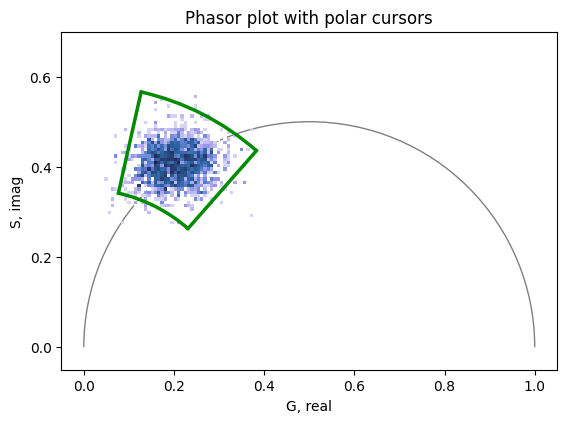

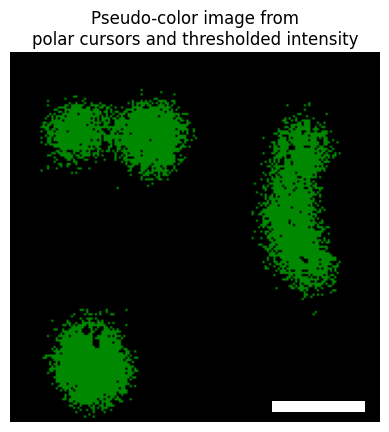

In [ ]:
import matplotlib.patches as patches

# Polar cursors

real = real_th_zoom_mssr1
imag = imag_th_zoom_mssr1
intensity = None #mean_th

#Phase and Modulation limits for cursors

line = 2.5
color = 'cmc.devon_r'
bins = 150

polar_mask = mask_from_polar_cursor(
    real, imag, phase_min, phase_max, modulation_min, modulation_max
)

plot = PhasorPlot(allquadrants=False, title='Phasor plot with polar cursors')
plot.hist2d(real, imag, cmap=color, bins = bins)
for i in range(len(phase_min)):
    plot.polar_cursor(
        phase=phase_min[i],
        phase_limit=phase_max[i],
        modulation=modulation_min[i],
        modulation_limit=modulation_max[i],
        color=CATEGORICAL[i + 2],
        linestyle='-', linewidth = line
    )
plot.show()

pseudo_color_beads = pseudo_color(*polar_mask, intensity = intensity, colors=CATEGORICAL[2:])

fig, ax = plt.subplots()
ax.set_title('Pseudo-color image from\npolar cursors and thresholded intensity')
ax.imshow(pseudo_color_beads)
# Add the scale bar
scalebar_width = 43  # in pixels
scalebar_height = 5  # in pixels
bar_color = 'white'  # or 'black' depending on your image

# Position: bottom left with a 10-pixel margin
x_pos = 120
y_pos = 160

scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax.add_patch(scalebar)
plt.axis('off')
plt.show()

In [ ]:
print(pseudo_color_beads.shape)

(170, 170, 3)
